# Detecting Fake News With Data Science
By: Minna Fingerhood, Natalie Del Rossi


### Import necessary packages

In [1]:
from functions import *
import pandas as pd
import spacy
nlp = spacy.load('en_core_web_lg')
from spacy.lang.en.stop_words import STOP_WORDS
from itertools import chain
import operator
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud, STOPWORDS
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import numpy as np
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize 
import string
from sklearn.linear_model import LogisticRegression

lemmatizer = WordNetLemmatizer() 
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package wordnet to /Users/Natalie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Natalie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1. Import cleaned dataframe (removed duplicates)

In [2]:
df = pd.read_csv('data.csv')
clean_df = clean_data(df)

### 2. Exploratory data analysis (EDA) and visualizations

(a) Distribution plot & also our baseline model which is roughly 50% accurate

[Text(0, 0, 'fake'), Text(0, 0, 'real')]

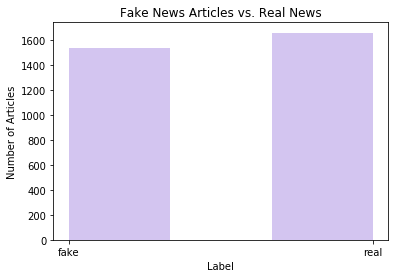

In [3]:
plt.title('Fake News Articles vs. Real News')
plt.xlabel('Type of News')
plt.ylabel('Number of Articles')
ax = sns.distplot(clean_df['Label'], color='mediumpurple', bins = 3, kde = False)
ax.set_xticks([0,1])
ax.set_xticklabels(['fake', 'real'])

In [4]:
clean_df['token_body'] = [nlp(clean_df['Body'][i]) for i in range(0, len(clean_df))]

In [5]:
real_articles = get_article_type(clean_df, 1)
fake_articles = get_article_type(clean_df, 0)
real_df = token_dataframe_from_dict(token_words(real_articles))
fake_df = token_dataframe_from_dict(token_words(fake_articles))
total_counts = token_dataframe_from_dict(token_words(clean_df))

(b) Bar chart of most common words seperated by fake news, real news, and total news:

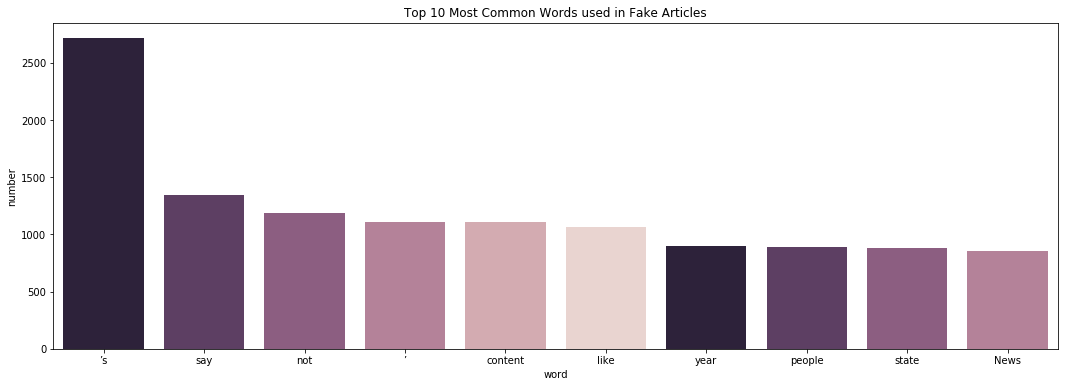

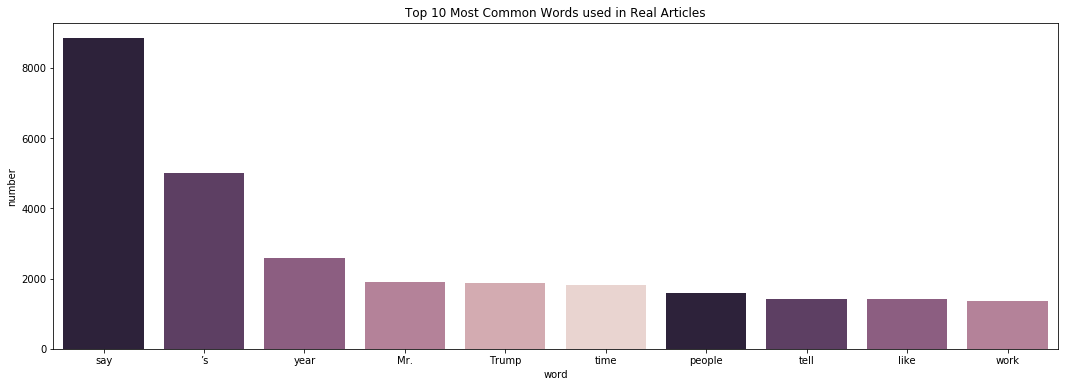

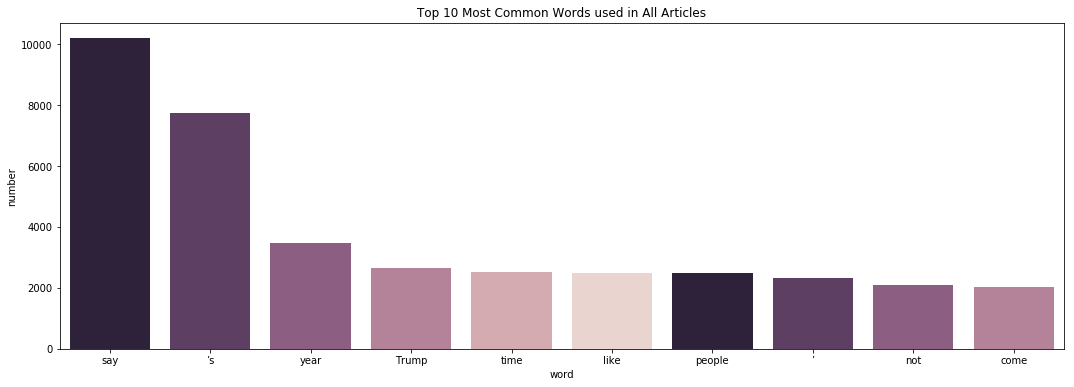

In [6]:
barplot(fake_df, 'Fake')
barplot(real_df, 'Real')
barplot(total_counts, 'All')

Tokenize, lemmatize, vectorize, and split for further EDA

In [7]:
#tokenized and lemmatized
clean_df = lemma(clean_df)

[nltk_data] Downloading package wordnet to /Users/Natalie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range = (1,2), stop_words='english')

tfidfv = tfidf.fit_transform(clean_df['lemma']).toarray()
label = clean_df.Label

X_train, X_test, y_train, y_test = train_test_split(tfidfv, clean_df['Label'], 
                                                    test_size = 0.3,random_state=1)

In [9]:
real_dfw = get_article_type(clean_df, 1)
fake_dfw = get_article_type(clean_df, 0)

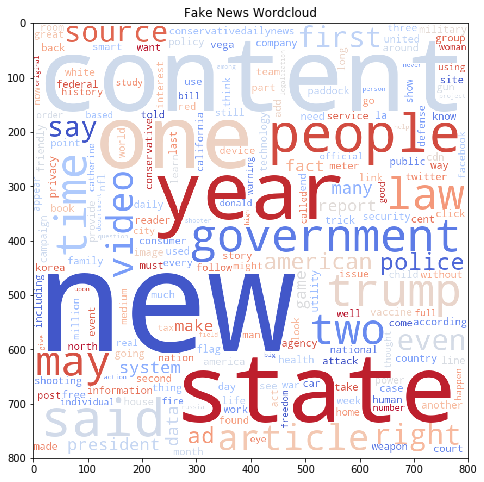

In [10]:
wordcloud(fake_dfw['lemma'], 'Fake')

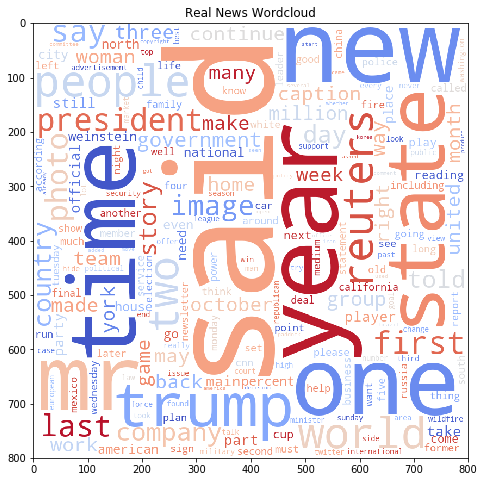

In [11]:
wordcloud(real_dfw['lemma'], 'Real')

### 3. Modeling

(a) Multinomial Naive Bayes

In [20]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_class = nb.predict(X_test)
metrics.accuracy_score(y_test, y_pred_class)

0.9311064718162839

[Text(0, 0.5, 'Fake'), Text(0, 1.5, 'Real')]

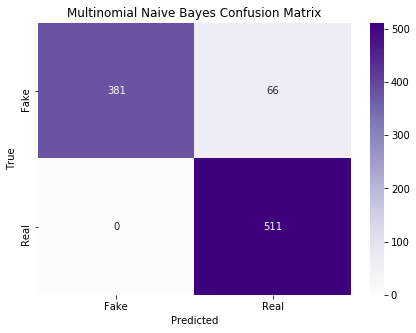

In [21]:
nbconfusion = metrics.confusion_matrix(y_test, y_pred_class)

plt.figure(figsize = (7, 5))
ax = plt.subplot()
sns.heatmap(nbconfusion, annot=True, fmt='d', ax = ax, cmap='Purples')
ax.set_xlabel('Predicted');ax.set_ylabel('True') 
ax.set_title('Multinomial Naive Bayes Confusion Matrix')
ax.xaxis.set_ticklabels(['Fake', 'Real']); ax.yaxis.set_ticklabels(['Fake', 'Real'])

In [22]:
y_pred_prob = nb.predict_proba(X_test)[:, 1]
metrics.roc_auc_score(y_test, y_pred_prob)

0.9916205886602136

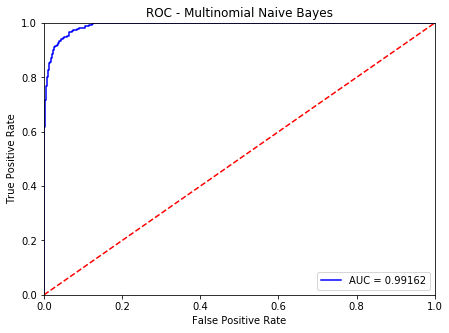

In [23]:
probs = nb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize = (7, 5))
plt.title('ROC - Multinomial Naive Bayes')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

(b) Logistic Regression

In [24]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_classl = logreg.predict(X_test)
y_pred_probl = logreg.predict_proba(X_test)[:, 1]
metrics.accuracy_score(y_test, y_pred_classl)

0.9718162839248434

[Text(0, 0.5, 'Fake'), Text(0, 1.5, 'Real')]

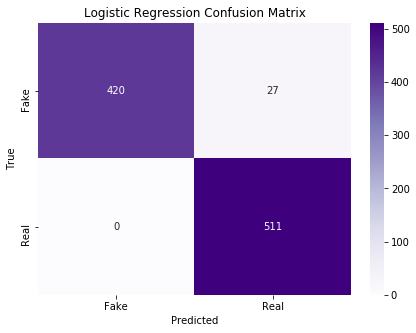

In [25]:
lrconfusion = metrics.confusion_matrix(y_test, y_pred_classl)

plt.figure(figsize = (7, 5))
ax = plt.subplot()
sns.heatmap(lrconfusion, annot=True, fmt='d', ax = ax, cmap='Purples')

ax.set_xlabel('Predicted');ax.set_ylabel('True'); 
ax.set_title('Logistic Regression Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Fake', 'Real']); ax.yaxis.set_ticklabels(['Fake', 'Real'])

In [26]:
metrics.roc_auc_score(y_test, y_pred_probl)

0.99917256596488

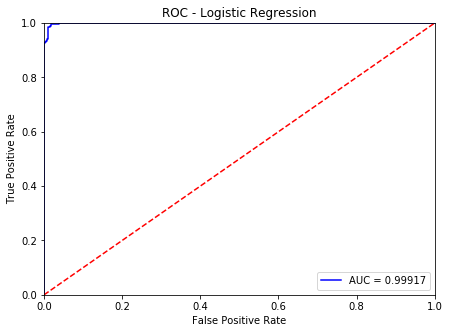

In [27]:
probs = logreg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize = (7, 5))
plt.title('ROC - Logistic Regression')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()